# Rainfall variability

Code and text partially sourced from Ridge to Reef Chapter 2. Why are we doing the Mann-Kendall tests? To show whether we can expect increasing or decreasing trends for a maize growing study area larger than in Franz et al. 2010 AWR. Either want to confirm this or show something new. 


Here are the pending to-dos:
There are four major ones: 1. What's the NA for sen's lope about?, 2. Clean up the time series without full years' worth of data, 3. Plot the legend seperately for easier stiching together, 4. Coefficient of Variability analysis.

- [ ] One final cleaning step: Well, does having incomplete years affect the statistics? For total rainfall yes, but for MAM, OND stats, possibly not. Need to do one final cleaning step: Write an algorithm that figures out number of missing days in a year. Then years with less than 50% of records (play around with this) remove. Can ask S/O for help  or see if there is a numpy module.
- [ ] What are the NaN values for the Theissen slopes? Manually changed this and need to take a deeper dive to see what's up
- [ ] Explain light cleaning that did or did not occur (1): Stations with 40+ years; stations with no more than X number of missing days; then work with this cleaned dataset
- [x] Which station has the longest record/most reliable data to use as center piece: Jacobson Farm, this is the same as Trenton's paper.
- [ ] Add the following to the metadata file: Start and end year for each station; number of missing data points; improve location accuracy for flagged stations
- [x] Figure out which alpha, lambda values are needed: by month? by year? or just average? Get these values for the 3-5 stations that we'll use for the paper. We use monthly alpha and lambda values. In the model you can select any stations. We're only considering Ol Jogi climatology.
- [x] Write function to generate each parameter description and resultant dataframe for analysis of station data for significant trends as in Mann and Sen test.
- [x] Have function that does all the stats and run for each parameter to generate table.
- [x] Pretty map of all the gauges.
- [x] Make Fig. 3 and Table 1 from Franz et al. 2010 my own. 
- [ ] Make sure I'm doing analysis correctly by veryfing results with [pymannkendall](https://pypi.org/project/pymannkendall/) package. 
- [ ] For Mann-Kendall test, also consider testing different definitions of seasons: MAMJ, FMAM, SOND, to see if the patterns hold. 

Changes made to `CETRADMetadata` csv as of 26/5/20:
- Got the UTM coords for stations without coordinates from [2016 Master's thesis](https://occrdata.unibe.ch/students/theses/msc/150.pdf). Interesting that this master's thesis has a lot more stations than we have. Worth reading this at some point. The locations do look rounded off though.
- Do I need to do QA/QC on my dataset as they've done?

Table of Contents:

0. [Rainfall Dynamics Write-Up](#intro)
1. [Import Model](#import)
2. [Light Data Cleaning](#qaqc)
3. [Mann-Kendall Tests](#min_max)
4. [Sen's method](#sen)
5. [Summary Table](#table)
6. [Trenton's Figure](#fig)
7. [More Variable Climate](#cv)
8. [Excess Code](#excess)

Last updated: 12 July 2020

<a id='intro'></a>
## 0. Rainfall Dynamics Write-Up

We examined rainfall patterns in the study site using daily station rainfall data provided by CETRAD in Nanyuki, Kenya. The gauges, show in [Map of study site], have record lengths between 7 to 81 years ([here](#min_max)). For computing statistics in Table 1, we used stations with records of 40+ years. We considered temporal trends in two parameters: $\alpha$, the average rain depth per rain event greater than 0 mm and $\lambda$, the average storm frequency per day during the two rainy seasons: long (March-May) and short (Oct.-Dec.) rains. In accordance with Franz et al. (2010), we found significant trends for "increasing $\alpha$ and decreasing $\lambda$ (p < 0.05) using the Mann-Kendall statistical test." ([here](#mannk))

<a id='import'></a>
## 1. Import model

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import sys
from datetime import datetime
from dateutil.relativedelta import *
import proplot as plot
import seaborn as sns
import scipy

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from scripts import mkt

## 1. Import clean dataset

In [2]:
df = pd.read_csv('../data/CETRAD/CETRAD_rainfall_QAQC.csv',sep=',')
df_raw = df

### Step 1. Select stations for use
For brevity in this document, stations were combined into one dataframe and annual rainfall totals were calculated in another csv which is brought back in here. The original objective is to select three representative stations of low, medium, and high total rainfall for the study region. And then calculate alphas, lambdas using those records.

In [3]:
# Import cleaned, merged datasets

df.columns
stations = ['ARDENCAPLE FARM', 'CHOGORIA FOREST STN',
       'CHUKA FOREST STN', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM',
       'JACOBSON FARM', 'KAMWAKI FARM', 'KINAMBA MOW', 'LARIAK FOREST STN',
       'LOLDOTO FARM', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH',
       'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MUTARA ADC FARM',
       'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NARO MORU MET STN',
       'OL BOLOSAT FOREST STN', 'OL DONYO FARM', 'OL JOGI FARM',
       'OL MYSOR FARM', 'PYRAMID OL JOGI', 'RUMURUTI MOW', 'SIRAJI (NRM)',
       'SIRIMA (NRM)', 'TIMAU MARANIA']

_a = pd.read_csv("../data/CETRAD/AnnualRainfall.csv")  # Read in the Annual Rainfall per station

# Only select rows that are in stations
AnnualRainfall = _a[_a.Station.isin(stations)]

# side note, average stats for a selection of farms
for s in stations:
    print('\n station:',s)
    d = AnnualRainfall[AnnualRainfall['Station'].str.match(s)]
    print('mean:',d['Annual Rainfall'].mean(),'std:',d['Annual Rainfall'].std())
    diff = d.dropna().max()['Year']-d.dropna().min()['Year']
    print('first year',d.dropna().min()['Year'],'last year',d.dropna().max()['Year'],'\n length',diff)



 station: ARDENCAPLE FARM
mean: 636.7406160031251 std: 226.33523230793688
first year 1948 last year 2015 
 length 67

 station: CHOGORIA FOREST STN
mean: 2225.5107142857146 std: 609.4755637111213
first year 1989 last year 2002 
 length 13

 station: CHUKA FOREST STN
mean: 1915.8455555555556 std: 453.1130812660115
first year 1988 last year 2006 
 length 18

 station: EMBORI FARM
mean: 687.7524350311111 std: 164.203217102076
first year 1967 last year 2011 
 length 44

 station: EMBU MET STN
mean: 1235.6999396444444 std: 321.88145362789595
first year 1976 last year 2011 
 length 35

 station: ENASOIT FARM
mean: 564.55625 std: 198.49695689143775
first year 1971 last year 2002 
 length 31

 station: JACOBSON FARM
mean: 735.1669944634147 std: 173.57129656727116
first year 1934 last year 2015 
 length 81

 station: KAMWAKI FARM
mean: 622.0732991509805 std: 235.52991001025606
first year 1965 last year 2015 
 length 50

 station: KINAMBA MOW
mean: 810.1428571428571 std: 149.6793172819078
first

## 3. Mann-Kendall Tests <a id='min_max'></a>
What is the min and max number of years in the record; groupby station and get difference between min and max year. 


In [4]:
# drop rows with NaN in Annual Rainfall
df = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)

vals = df.groupby('Station')['Year'].agg(np.ptp).to_frame()
vals['Year'].min()

print('shortest record',vals['Year'].min(),'\n longest record',vals['Year'].max())

shortest record 9 
 longest record 81


### 1b. What are the stations with 30+ years of data? (Trenton investigated 30, 40, 50)

In [5]:
my_stations = vals[vals.Year > 29]
print('total number of stations',len(vals),'\n stations with 40+ yrs',len(my_stations))

# turn my_stations into list so that for the following statistics we only use these stations
my_stations.reset_index(inplace=True)
stations = my_stations['Station'].tolist()

# test
print('this needs to be true:',len(my_stations) == len(stations)) # need this to be true

# make sure the orig. df is longer than the subsetted one
print('make sure this orig. df:',len(df),'is longer than the subsetted one:', len(df[df.Station.isin(stations)]))

# now name list of stations to use as shortlist
shortlist = df[df.Station.isin(stations)]

total number of stations 30 
 stations with 40+ yrs 18
this needs to be true: True
make sure this orig. df: 1113 is longer than the subsetted one: 912


### Define function for Mann-Kendall test

In [6]:
def mkt_stats(ALPHA=0.05, EPS=1, HA="upordown", DF=shortlist, COL='Station',tseries = 'Year', xseries = 'Annual Rainfall'):
    """" Usage:
    
    # now can try running statistical test on Annual Rainfall
    # need to run this for each station. Can do this in a for loop.
    # for every station which is a row in shortlist, do the statistical calculation
    # we want to know whether the trend is significant (p), the slope per station (m) to get the mean and standard error

    """
    results = []

    for s in stations:
        #print(shortlist[shortlist['Station'].str.match(s)])
        d = DF[DF[COL].str.match(s)]

        t_ = d[tseries].array # get the years for each station
        x_ = d[xseries].array # get the annual rainfall for each station

        # this is for any individual station
        MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
        # scipy Theil-Sen estimator
        ss, medintercept, lo_slope, up_slope = scipy.stats.mstats.theilslopes(x_, alpha=ALPHA)

        # cat into single dataframe
        df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p, 'SenSlope':ss}, index=[0])
        results.append(df)

    final = pd.concat(results)
    pct_annual_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
    l_accept_annual_rf = len(final[final['Hypothesis_test'].str.match('accept')])
    accept_annual_rf = final[final['Hypothesis_test'].str.match('accept')]
    
    # percent of stations with statistically sig. trends
    print('number of stations with sig. trends:',l_accept_annual_rf,
          '\n percent of stations with sig. trends:',pct_annual_rf)

    # calculate the mean and se of the slopes
    m_annual_rf = accept_annual_rf['Slope'].mean()
    se_annual_rf = accept_annual_rf['Slope'].var()
    ss_annual_rf = final['SenSlope'].mean()
    sse_annual_rf = scipy.stats.sem(final['SenSlope'])
    

    # what stations are significant?
    print(final[final['Hypothesis_test'].str.match('accept')].Station)
    
    return final, pct_annual_rf, l_accept_annual_rf, accept_annual_rf, m_annual_rf, se_annual_rf, ss_annual_rf, sse_annual_rf    

In [98]:
# # testing around theil sen
# d = shortlist[shortlist['Station'].str.match('ARCHER')]
# x_ = d['Annual Rainfall'].array
# t_ = d['Year'].array
# # y = dependent variable
# # x = independent variable; can be left out.
# ss, medintercept, lo_slope, up_slope = scipy.stats.mstats.theilslopes(y=x_, alpha=0.95) # x=t_,
# ss

# scipy.stats.sem(final['SenSlope'])
# final['SenSlope'].mean()

### 1c. Are rain trends increasing or decreasing for Annual Rainfall (mm)? <a id='mannk'></a>
- Mann-Kendall test on Annual rainfall (mm). I used the package [mkt](https://up-rs-esp.github.io/mkt/#updated-formulae-for-implementation). To do this, I forked the original directory and moved the script `mkt.py` into maize-Toff/scripts so that I could access the function.
- Select stations with 40+ years of data -- not sure why Trenton used this and whether I need to justify.

Need to go through and read the docs to make sure what I'm assuming is correct:
1. What is the least count? Minimum possible measurement value. Some measure of error? When you change this number around the final result is not that different (same for 1 vs. 0.1, for example.)
2. For the alpha, going to use the same value as Trenton: 0.05
3. Ha is the type of test: one sided or two sided: up, down or up or down. I went with the last one to account for either increasing or decreasing trends.

In [7]:
final, pct_annual_rf, l_accept_annual_rf, accept_annual_rf, m_annual_rf, se_annual_rf, ss_annual_rf, sse_annual_rf = mkt_stats()

number of stations with sig. trends: 1 
 percent of stations with sig. trends: 5.555555555555555
0    TIMAU MARANIA
Name: Station, dtype: object


In [8]:
scipy.stats.sem(final['SenSlope'])

0.6321752576085893

### 1d. Rain trends for OND and MAM

Critical question: What happens if rains don't always start in May or October?


In [9]:
# try using df2 dataset

#df_raw = df_raw.drop('Datetime.1',axis=1)

# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

# Assign two seasons: Short rains = months 3,4,5; Long rains = 10,11,12

df1 = (df.assign(Season = np.select([df['Month'].between(3,5),
                                         df['Month'].between(10,12)],
                                         ['LongRains','ShortRains'], default=None))# this is right
         .groupby(['variable','Season','Year']).value
         .sum()
         .reset_index(name='SummedValue') #.replace(0, np.NaN).dropna()
          )
# For some reason the LongRains print first, but I checked this out in a csv
# and it's fine. For check, long rains Archers post 1957 should be 83.8 and it is. 
#df1 #(5999 rows and 4 columns)

# This solution also works but isn't as clear
#bins = [0,3,8,11]
#s = pd.cut(df['Month'],bins,labels=['1:3','irrelevant','9:11'])

#(df[s.isin(['1:3','9:11'])].assign(MonthGroups=s.astype(str))
#.groupby(['variable','MonthGroups','Year'])['value'].sum().reset_index())
df1

# Define two seasons
df_lr = df1.loc[df1['Season'] == 'LongRains']
df_sr = df1.loc[df1['Season'] == 'ShortRains']

# MK Test for Short Rains
final_ond, pct_ond_rf, l_accept_ond_rf, accept_ond_rf, m_ond_rf, se_ond_rf, ss_ond_rf, sse_ond_rf  = mkt_stats(DF=df_sr, COL='variable',tseries = 'Year', xseries = 'SummedValue')

df_lr_tot = df_lr
df_sr_tot = df_sr

TypeError: loop of ufunc does not support argument 0 of type float which has no callable fabs method

In [10]:
# Long rains MKT Test
final_mam, pct_mam_rf, l_accept_mam_rf, accept_mam_rf, m_mam_rf, se_mam_rf,ss_mam_rf, sse_mam_rf  = mkt_stats(DF=df_lr, COL='variable',tseries = 'Year', xseries = 'SummedValue')

TypeError: loop of ufunc does not support argument 0 of type float which has no callable fabs method

### 1e. Average arrival rate of rain events (lambda) for OND and MAM.


In [11]:
# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

df1 = (df.assign(Season = np.select([df['Month'].between(3,5),
                                         df['Month'].between(10,12)],
                                         ['LongRains','ShortRains'], default=None))# this is right
         .groupby(['variable','Season','Datetime','Year']).value
         .sum()
         .reset_index(name='Value') #.replace(0, np.NaN).dropna()
         )
rainfall = df1
#Lambda by season
#for s in station:
    # First, find all the rows in the data where it rained and group by month.
#    rain_days = rainfall.loc[rainfall[station] > 0]

# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall.Value > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall.Value >= 0]

rain_days.head()
rainfall

lambda_by_season = (
    rain_days.groupby(['Season','variable','Year'])['Value'].count() /
    all_days.groupby(['Season','variable','Year'])['Value'].count()
    )

#pd.DataFrame(lambda_by_season).plot.bar() # this is a monstruous plot

# get to dataframe

lbs = lambda_by_season.to_frame().reset_index()

# Define two seasons
df_lr = lbs.loc[lbs['Season'] == 'LongRains']
df_sr = lbs.loc[lbs['Season'] == 'ShortRains']

df_lr_l = df_lr
df_sr_l = df_sr

TypeError: '>' not supported between instances of 'str' and 'int'

In [12]:
# Long rains MKT Test
final_mamL, pct_mamL_rf, l_accept_mamL_rf, accept_mamL_rf, m_mamL_rf, se_mamL_rf, ss_mamL_rf, sse_mamL_rf  = mkt_stats(EPS=0.001, DF=df_lr, COL='variable',tseries = 'Year', xseries = 'Value')
sse_mamL_rf
final_mamL

# why are there NaNs? Need to look into this.
print(sse_mamL_rf)

KeyError: 'Value'

In [13]:
# Short rains MKT Test
final_ondL, pct_ondL_rf, l_accept_ondL_rf, accept_ondL_rf, m_ondL_rf, se_ondL_rf, ss_ondL_rf, sse_ondL_rf  = mkt_stats(EPS=0.001, DF=df_sr, COL='variable',tseries = 'Year', xseries = 'Value')

# Note: EPS = 0.001 # Needed to change this value -- what does Trenton use?

scipy.stats.sem(final['SenSlope'])
print(se_ondL_rf)

KeyError: 'Value'

In [14]:
sse_ondL_rf

NameError: name 'sse_ondL_rf' is not defined

### 1f. Average rain per storm (alpha) for OND and MAM.


In [15]:
alpha_by_season = rain_days.groupby(['Season','Year','variable'])['Value'].mean()
alpha_by_season

abys = alpha_by_season.to_frame().reset_index()

# Define two seasons
df_lr = abys.loc[abys['Season'] == 'LongRains']
df_sr = abys.loc[abys['Season'] == 'ShortRains']
#df_sr

df_lr_a = df_lr
df_sr_a = df_sr

NameError: name 'rain_days' is not defined

In [16]:
# Long rains MKT Test

final_mamA, pct_mamA_rf, l_accept_mamA_rf, accept_mamA_rf, m_mamA_rf, se_mamA_rf, ss_mamA_rf, sse_mamA_rf  = mkt_stats(EPS=0.001, DF=df_lr, COL='variable',tseries = 'Year', xseries = 'Value')

print(sse_mamA_rf)


KeyError: 'Value'

In [109]:
# Short rains MKT Test
final_ondA, pct_ondA_rf, l_accept_ondA_rf, accept_ondA_rf, m_ondA_rf, se_ondA_rf, ss_ondA_rf, sse_ondA_rf  = mkt_stats(EPS=0.001, DF=df_sr, COL='variable',tseries = 'Year', xseries = 'Value')


number of stations with sig. trends: 5 
 percent of stations with sig. trends: 27.77777777777778
0    ARDENCAPLE FARM
0      JACOBSON FARM
0       LOLDOTO FARM
0    MUTARA ADC FARM
0      TIMAU MARANIA
Name: Station, dtype: object


a question... is it mean and standard error of all stations or just the significant ones?

<a id='sen'></a>

## 4. Use Sen's method for Mean slope of all stations

Trenton cited Maidment's [Handbook of hydrology](https://babel.hathitrust.org/cgi/pt?id=mdp.39015029254243&view=1up&seq=993), which brought me to this original cite here: 

16.5 Sen's Non parametric estimator of slope [Gilbert 1987](https://www.osti.gov/servlets/purl/7037501).
There a few pythoh packages that can return this for me: [scipy](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.mstats.theilslopes.html); [pymannkendall](https://pypi.org/project/pymannkendall/); [TheilSen](https://davidcarslaw.github.io/openair/reference/TheilSen.html).
[SciKitLearn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html)

#### But what is _it_?
- Sen's method (1968) discovers trends in univariate data which is more resistent to outliers than a normal slope calculation. Breakdown point is 0.29. It is nonparametric. Also called Theil-Sen Regression. Steps are:

    1. Calculate slopes for all ordered pair time points.
    2. Find the median of all slopes. 


I ended up using scipy's function, [theilslopes](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.theilslopes.html).

In [110]:
# scipy

#import scipy
#medslope, medintercept, lo_slope, up_slope = scipy.stats.mstats.theilslopes(test.Value, x=None, alpha=0.95)

<a id='table'></a>

## 5. Make table

In [111]:
# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Total rainfall (mm)','Total rainfall (mm)',  'Annuall rainfall (mm)', 
          'Average rain per storm, 'r'$\alpha $, (mm)','Average rain per storm,  'r'$\alpha $, (mm)',
         'Average arrival rate of rain, λ, (day$^{-1}$)',
         'Average arrival rate of rain, λ, (day$^{-1}$)']
perc_stn = [pct_ond_rf,pct_mam_rf,pct_annual_rf,pct_ondA_rf,pct_mamA_rf,pct_ondL_rf,pct_mamL_rf]
m_slope =  [m_ond_rf,m_mam_rf,m_annual_rf,m_ondA_rf,m_mamA_rf,m_ondL_rf,m_mamL_rf] # This uses's Sens's method. Not sure what that is. 
var_slope = [se_ond_rf,se_mam_rf,se_annual_rf,se_ondA_rf,se_mamA_rf,se_ondL_rf,se_mamL_rf]
s_slope = [ss_ond_rf,ss_mam_rf,ss_annual_rf,ss_ondA_rf,ss_mamA_rf,ss_ondL_rf,ss_mamL_rf]
se_slope = [sse_ond_rf,sse_mam_rf,sse_annual_rf,sse_ondA_rf,sse_mamA_rf,sse_ondL_rf,sse_mamL_rf] # Note! Manually changed this to make it work but requires a deeper dive

season = ['Short rains', 'Long rains','Both','Short rains','Long rains','Short rains','Long rains']

table1 = pd.DataFrame({'Parameter description ':p_desc,
                       'Season': season,
                       '% of stations with significant trends (p < 0.05, Mann-Kendall test)': perc_stn,
                       #'Mean slope': m_slope,
                       #'SE slopes':var_slope,
                         'Mean slope of all stations using Theil-Sen method':s_slope,
                     'Standard error of slopes':se_slope})

table1 = table1.round({'% of stations with significant trends (p < 0.05, Mann-Kendall test)':1,'Mean slope of all stations using Theil-Sen method':4
                      }) #
#table1.to_csv('table1.csv',sep=',')

table1

# make easier table for latex export.. Just the numbers!
#export = table1[table1.columns[-3:]]
#export.to_latex(index=False)

# I think the NaNs had to do with rounding
#print(sse_ondL_rf)

,Parameter description,Season,"% of stations with significant trends (p < 0.05, Mann-Kendall test)",Mean slope of all stations using Theil-Sen method,Standard error of slopes
0,Total rainfall (mm),Short rains,5.6,0.4161,0.218988
1,Total rainfall (mm),Long rains,0.0,-0.4615,0.301135
2,Annuall rainfall (mm),Both,5.6,-0.0875,0.632175
3,"Average rain per storm, $\alpha $, (mm)",Short rains,27.8,0.0239,0.011982
4,"Average rain per storm, $\alpha $, (mm)",Long rains,27.8,0.0199,0.011599
5,"Average arrival rate of rain, λ, (day$^{-1}$)",Short rains,33.3,-0.0002,NaN
6,"Average arrival rate of rain, λ, (day$^{-1}$)",Long rains,22.2,-0.0010,NaN


<a id='fig'></a>
## 6. Make a figure like Trenton's

Using one location.. JACOBSON FARM

This code is sooooooooo ugly. But it works.

In [95]:
if positive == True:
        textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'+$  %2.0f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, ))) 
    else:
        textstr = '\n'.join((
        r'$ y = %.2f$x' % (m, )+'$  %2.0f$' % (b, ),
        r'$r^2 = %.2f$' % (R_squared, )))

    props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5) # , ec="b"

    # place a text box in upper left in axes coords
    plt.text(ann_x, ann_y, textstr, fontsize=10, #transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

TODO: Can I plot the legend as a seperate figure?

0.04997446124600591


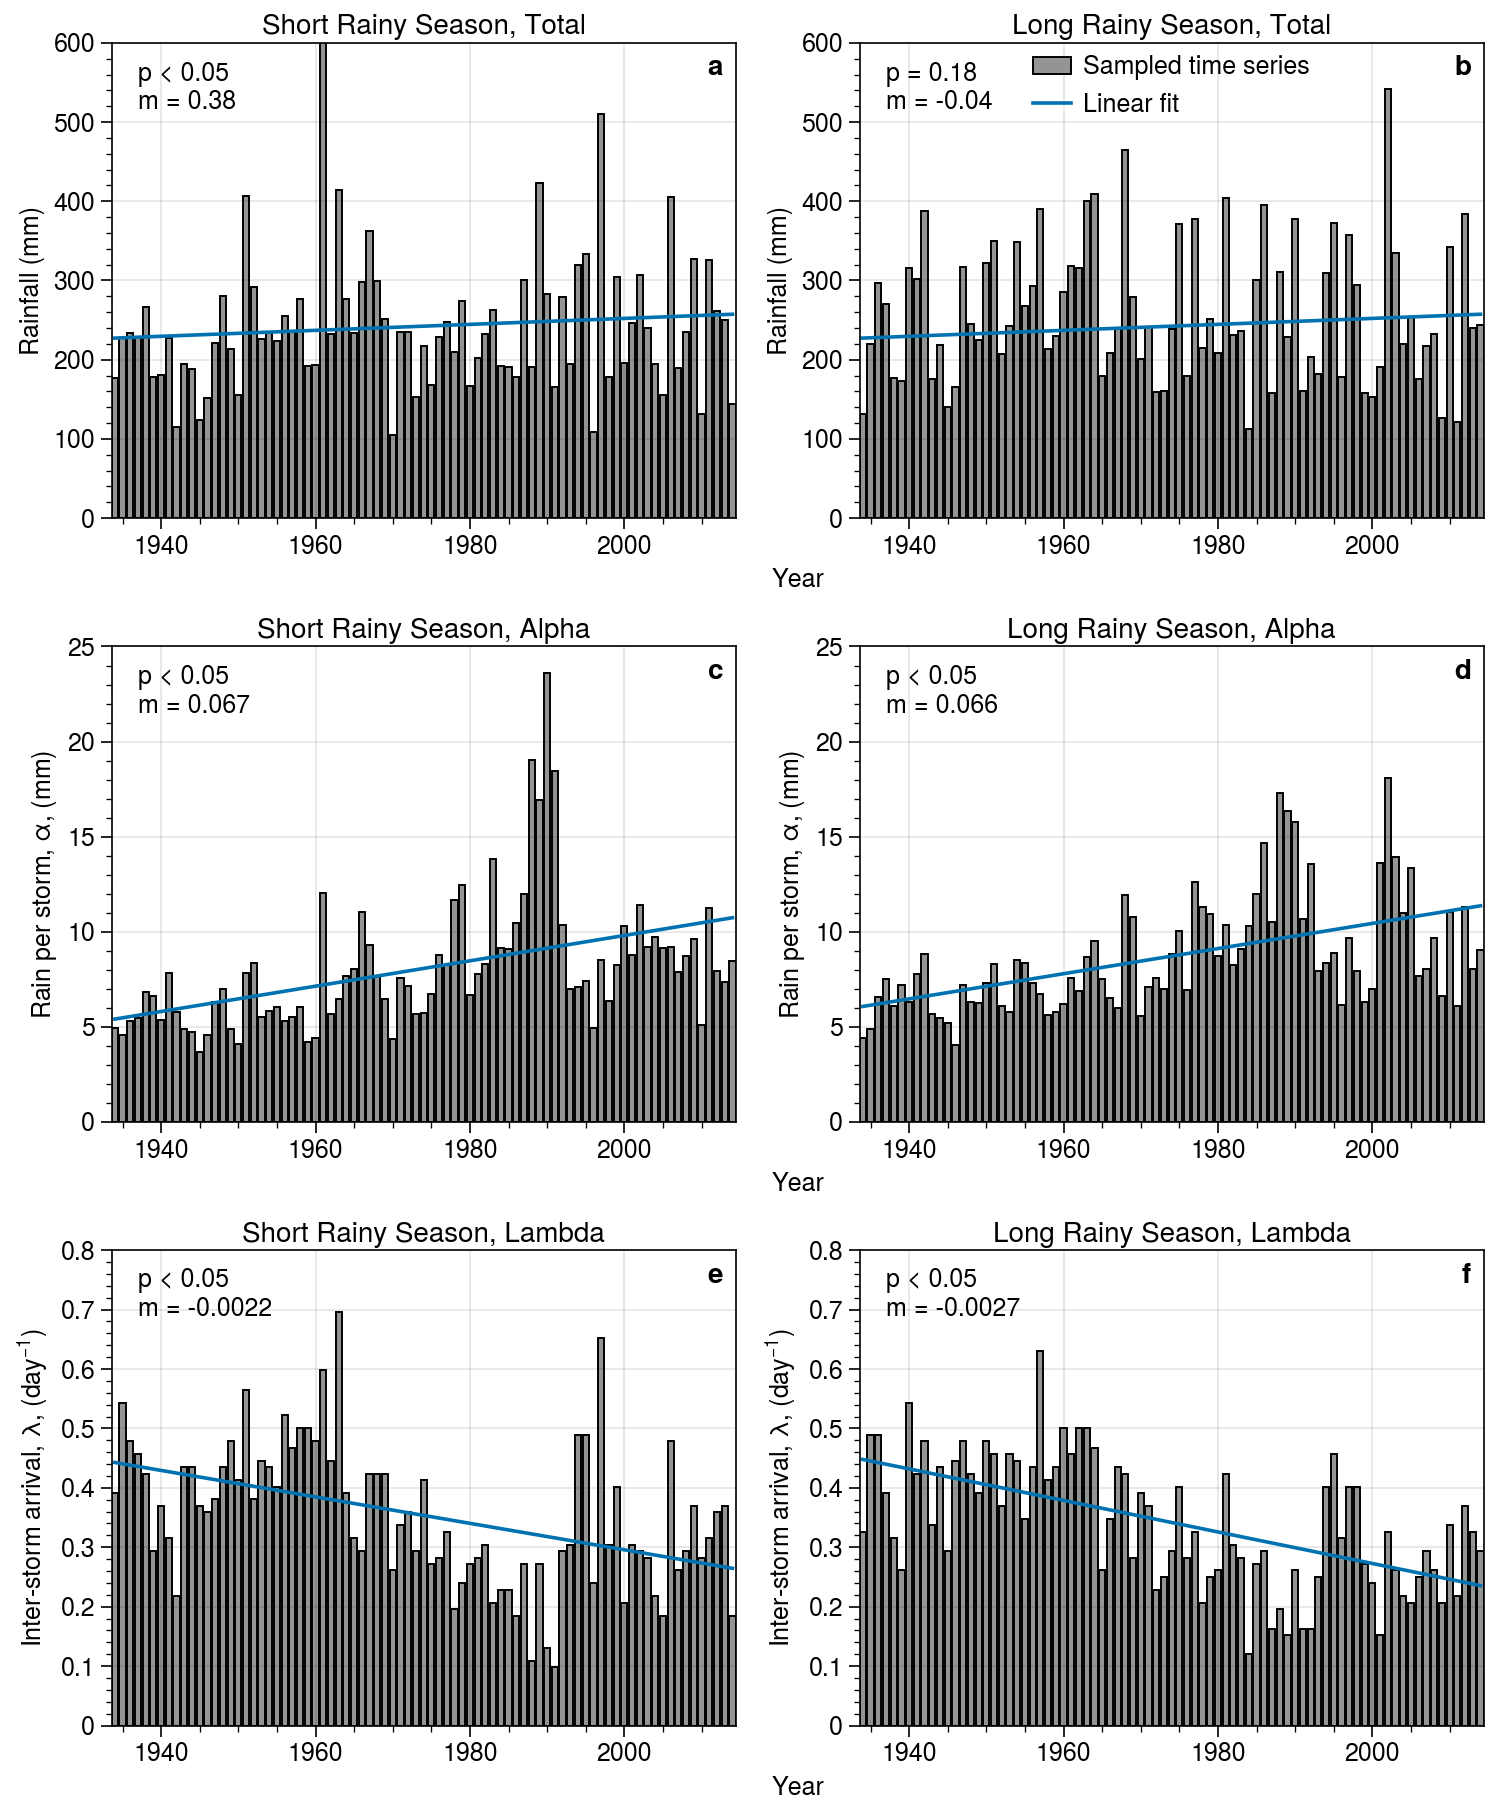

In [102]:
station = 'JACOBSON FARM'
#df_sr_tot = df_sr_tot.set_index('Year')

fig, axs = plot.subplots(nrows=3, ncols=2, share=0, spanx=3, journal='agu4') #span=1, axwidth=1)share=0,
# axwidth=2, 

axs.format(
        xlabel='Year', #ylabel='ylabel', suptitle='test',
        abc=True, abcloc='ur' #grid=False, xticks=25, yticks=5
    )

ALPHA = 0.05

# TOTAL, SHORT RAINS --- this is soooo janky but it works.   
test = df_sr_tot.loc[df_sr_tot['variable'] == station] # dataframe with time series
test2 = final_ond.loc[final_ond['Station'] == station] # dataframe with mk results

yval = test['SummedValue'].tolist()
idx = test['Year'].tolist()
df = pd.DataFrame(yval, columns = ['SummedValue'], index=idx)
m = test2['Slope'].item()
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
#t = [float(item) for item in idx]
t = df.index
x = test['SummedValue']
df['Rainfall (mm)'] = m * t + c
df['x_str'] = idx
print(p)

# plot results
axs[0,0].bar(df.SummedValue, color='gray') #"k.-", label="Sampled time series"
axs[0,0].format(title='Short Rainy Season, Total') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[0,0].plot(df['Rainfall (mm)'])
axs[0,0].set_ylim([0, 600])

#axs[0,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 516))
axs[0,0].annotate("p < 0.05\nm = %.2f" % (m), xy=(1937, 516))


# TOTAL, LONG RAINS    
test = df_lr_tot.loc[df_lr_tot['variable'] == station]
test2 = final_mam.loc[final_mam['Station'] == station]

yval = test['SummedValue'].tolist()
idx = test['Year'].tolist()
df = pd.DataFrame(yval, columns = ['SummedValue'], index=idx)
df['Rainfall (mm)'] = m * t + c
df['x_str'] = idx
m = test2['Slope'].item()
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
#t = [float(item) for item in idx]
t = df.index
x = test['SummedValue']

# plot results
#axs[0,1].bar(df.SummedValue, color='gray') #"k.-", label="Sampled time series"
axs[0,1].format(title='Long Rainy Season, Total') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
#axs[0,1].plot(df['Rainfall (mm)'])
axs[0,1].set_ylim([0, 600])

axs[0,1].annotate("p = %.2f\nm = %.2f" % (p, m), xy=(1937, 516)) # 


axs[0,1].bar(
        df.SummedValue, color='gray', label='Sampled time series', legend='r', #cycle='Set3',
        legend_kw={'ncols': 1, 'frame': False} #'title': 'Legend'
    )

    
axs[0,1].plot(df['Rainfall (mm)'], label='Linear fit', legend='r', #cycle='Set3',color='blue', 
        legend_kw={'loc':'upper center','ncols': 1, 'frame': False} # , 'title': 'Legend'
    )    


# ALPHA, SHORT RAINS
test = df_sr_a.loc[df_sr_a['variable'] == station]
test2 = final_ondA.loc[final_ondA['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Rain per storm, 'r'$\alpha $, (mm)'] = m * t + c
df['x_str'] = idx
df

# plot results
axs[1,0].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[1,0].format(title='Short Rainy Season, Alpha') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[1,0].plot(df['Rain per storm, 'r'$\alpha $, (mm)'])
axs[1,0].set_ylim([0, 25])

#axs[1,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 21.5))
axs[1,0].annotate("p < 0.05\nm = %.3f" % (m), xy=(1937, 21.5))


# ALPHA, LONG RAINS
test = df_lr_a.loc[df_lr_a['variable'] == station]
test2 = final_mamA.loc[final_mamA['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Rain per storm, 'r'$\alpha $, (mm)'] = m * t + c
df['x_str'] = idx
df

# For this one have legend
# Add legend below

#axs[1,1].bar(
#        df.Value, color='gray', label='Sampled time series', legend='r', #cycle='Set3',
#        legend_kw={'ncols': 1, 'frame': True} #'title': 'Legend'
#    )

    
#axs[1,1].plot(df['Rain per storm, 'r'$\alpha $, (mm)'], label='Linear fit', legend='r', #cycle='Set3',color='blue', 
#        legend_kw={'loc':'upper right','ncols': 1, 'frame': True} # , 'title': 'Legend'
#    )    


    
axs[1,1].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[1,1].format(title='Long Rainy Season, Alpha') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[1,1].plot(df['Rain per storm, 'r'$\alpha $, (mm)'])
axs[1,1].set_ylim([0, 25])
#axs[1,1].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 21.5)) #21.5/25 = 0.86
axs[1,1].annotate("p < 0.05\nm = %.3f" % (m), xy=(1937, 21.5)) #21.5/25 = 0.86


# LAMBDA, SHORT RAINS
test = df_sr_l.loc[df_sr_l['variable'] == station]
test2 = final_ondL.loc[final_ondL['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Inter-storm arrival, λ, (day$^{-1}$)'] = m * t + c
df['x_str'] = idx

# plot results
axs[2,0].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[2,0].format(title='Short Rainy Season, Lambda') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[2,0].plot(df['Inter-storm arrival, λ, (day$^{-1}$)'])
axs[2,0].set_ylim([0, 0.8])
#axs[2,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 0.69)) # 0.85
axs[2,0].annotate("p < 0.05\nm = %.4f" % (m), xy=(1937, 0.69)) # 0.85


# LAMBDA, LONG RAINS
test = df_lr_l.loc[df_lr_l['variable'] == station]
test2 = final_mamL.loc[final_mamL['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Inter-storm arrival, λ, (day$^{-1}$)'] = m * t + c
df['x_str'] = idx

axs[2,1].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[2,1].format(title='Long Rainy Season, Lambda') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[2,1].plot(df['Inter-storm arrival, λ, (day$^{-1}$)'])
axs[2,1].set_ylim([0, 0.8])

# Annotations
#axs[2,1].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 0.69))
axs[2,1].annotate("p < 0.05\nm = %.4f" % (m), xy=(1937, 0.69))

# Export figure as a jpg and pdf
#plt.savefig('../output/figures/jacobson_ts.pdf')
#plt.savefig('../output/figures/jacobson_ts.png')


<a id='cv'></a>
## 7. How do we make for a more variable climate?

Original: Increase alpha by 15%; decrease lambda by 15%
New way: Go back in record to see what typical alpha values were early in the record compared to now. 

### For varied climate, get some reasonable values for the first 5 years of record versus last 5 years of record

In [50]:
df_lr_a.loc[df_lr_a['variable'] == station].head(5)

,Season,Year,variable,Value
0,LongRains,1934,JACOBSON FARM,4.386667
1,LongRains,1935,JACOBSON FARM,4.884444
2,LongRains,1936,JACOBSON FARM,6.591111
3,LongRains,1937,JACOBSON FARM,7.511111
4,LongRains,1938,JACOBSON FARM,6.113793


In [43]:
# Alphas
# Long rains, mean and variances
# First five years
print(df_lr_a.loc[df_lr_a['variable'] == station].head(4).Value.mean(), df_lr_a.loc[df_lr_a['variable'] == station].head(4).Value.var())
# Last five years
print(df_lr_a.loc[df_lr_a['variable'] == station].tail(3).Value.mean(), df_lr_a.loc[df_lr_a['variable'] == station].tail(3).Value.var())

# Rounded off:
# Historic: 5.84
# Present: 9.44
# Calculate percent change
# 61.6438% increase
# 38.1356% decrease 

# Note to self: what is the difference between percent change and percent difference?


5.843333333333333 2.127333333333332
9.443101877632532 2.8206241270924957


In [47]:
# Lambdas
# Long rains, mean and variance
# First five years
print(df_sr_l.loc[df_sr_l['variable'] == station].head(5).Value.mean(),df_sr_l.loc[df_sr_l['variable'] == station].head(5).Value.var())
print(df_sr_l.loc[df_sr_l['variable'] == station].tail(5).Value.mean(),df_sr_l.loc[df_sr_l['variable'] == station].tail(5).Value.var())

# Rounded off:
# Historic: 0.459
# Present: 0.302
# 34.2048% decrease
# 51.9868% increase

0.45869565217391306 0.0033317580340264637
0.3021739130434783 0.005517485822306238


Use these numbers in 2-rainfall-variability-sims notebook

### First 3-5 years of Jacobson Farm data.

### Last 3-5 years of Jacobson Farm data.

### Nevermind, cv was not very different between the two.
Do first half of the record vs. second half of the record.

In [ ]:
pd.DataFrame(df_raw[station])

# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

In [82]:
# how many years is jacobson farm?
df.loc[df['variable'] == station]
print(2015-1934)

81


In [83]:
first5 = df.loc[df['variable'] == station].head(365*40) # instead doing first 40 years of record
last5 = df.loc[df['variable'] == station].tail(365*40)
# there is a better way of doing this that accounts for leap years
# need to redo with groupby

# only do rainy values
first5[first5 == 0] = np.nan
last5[last5 == 0] = np.nan

In [84]:
#last5_cv = 
last5.value.std()/last5.value.mean()

0.9821817456632649

In [86]:
first5.value.std()/first5.value.mean()

1.1225668963992914

In [93]:
# maybe instead of daily rainfall it is annual rainfall
AnnualRainfall.loc[AnnualRainfall['Station'] == station]
#AnnualRainfall
#df = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)

# TODO: It looks like 2015 needs to be removed from this record.



,Year,Station,Annual Rainfall
1245,1934,JACOBSON FARM,419.900000
1246,1935,JACOBSON FARM,773.700000
1247,1936,JACOBSON FARM,895.100000
1248,1937,JACOBSON FARM,748.700000
1249,1938,JACOBSON FARM,694.200000
...,...,...,...
1323,2012,JACOBSON FARM,936.000079
1324,2013,JACOBSON FARM,864.500085
1325,2014,JACOBSON FARM,565.500045
1326,2015,JACOBSON FARM,19.000001


In [100]:
jf = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)
jf.loc[jf['Station'] == station]
# Still need to drop 2015, do this somewhere above. 

# first 40
jf['Annual Rainfall'].head(40).std()/jf['Annual Rainfall'].head(40).mean()


0.4526404104407736

In [101]:
# last 40
jf['Annual Rainfall'].tail(40).std()/jf['Annual Rainfall'].tail(40).mean()


0.282674003469694

<a id='excess'></a>
## 8. Excess Code

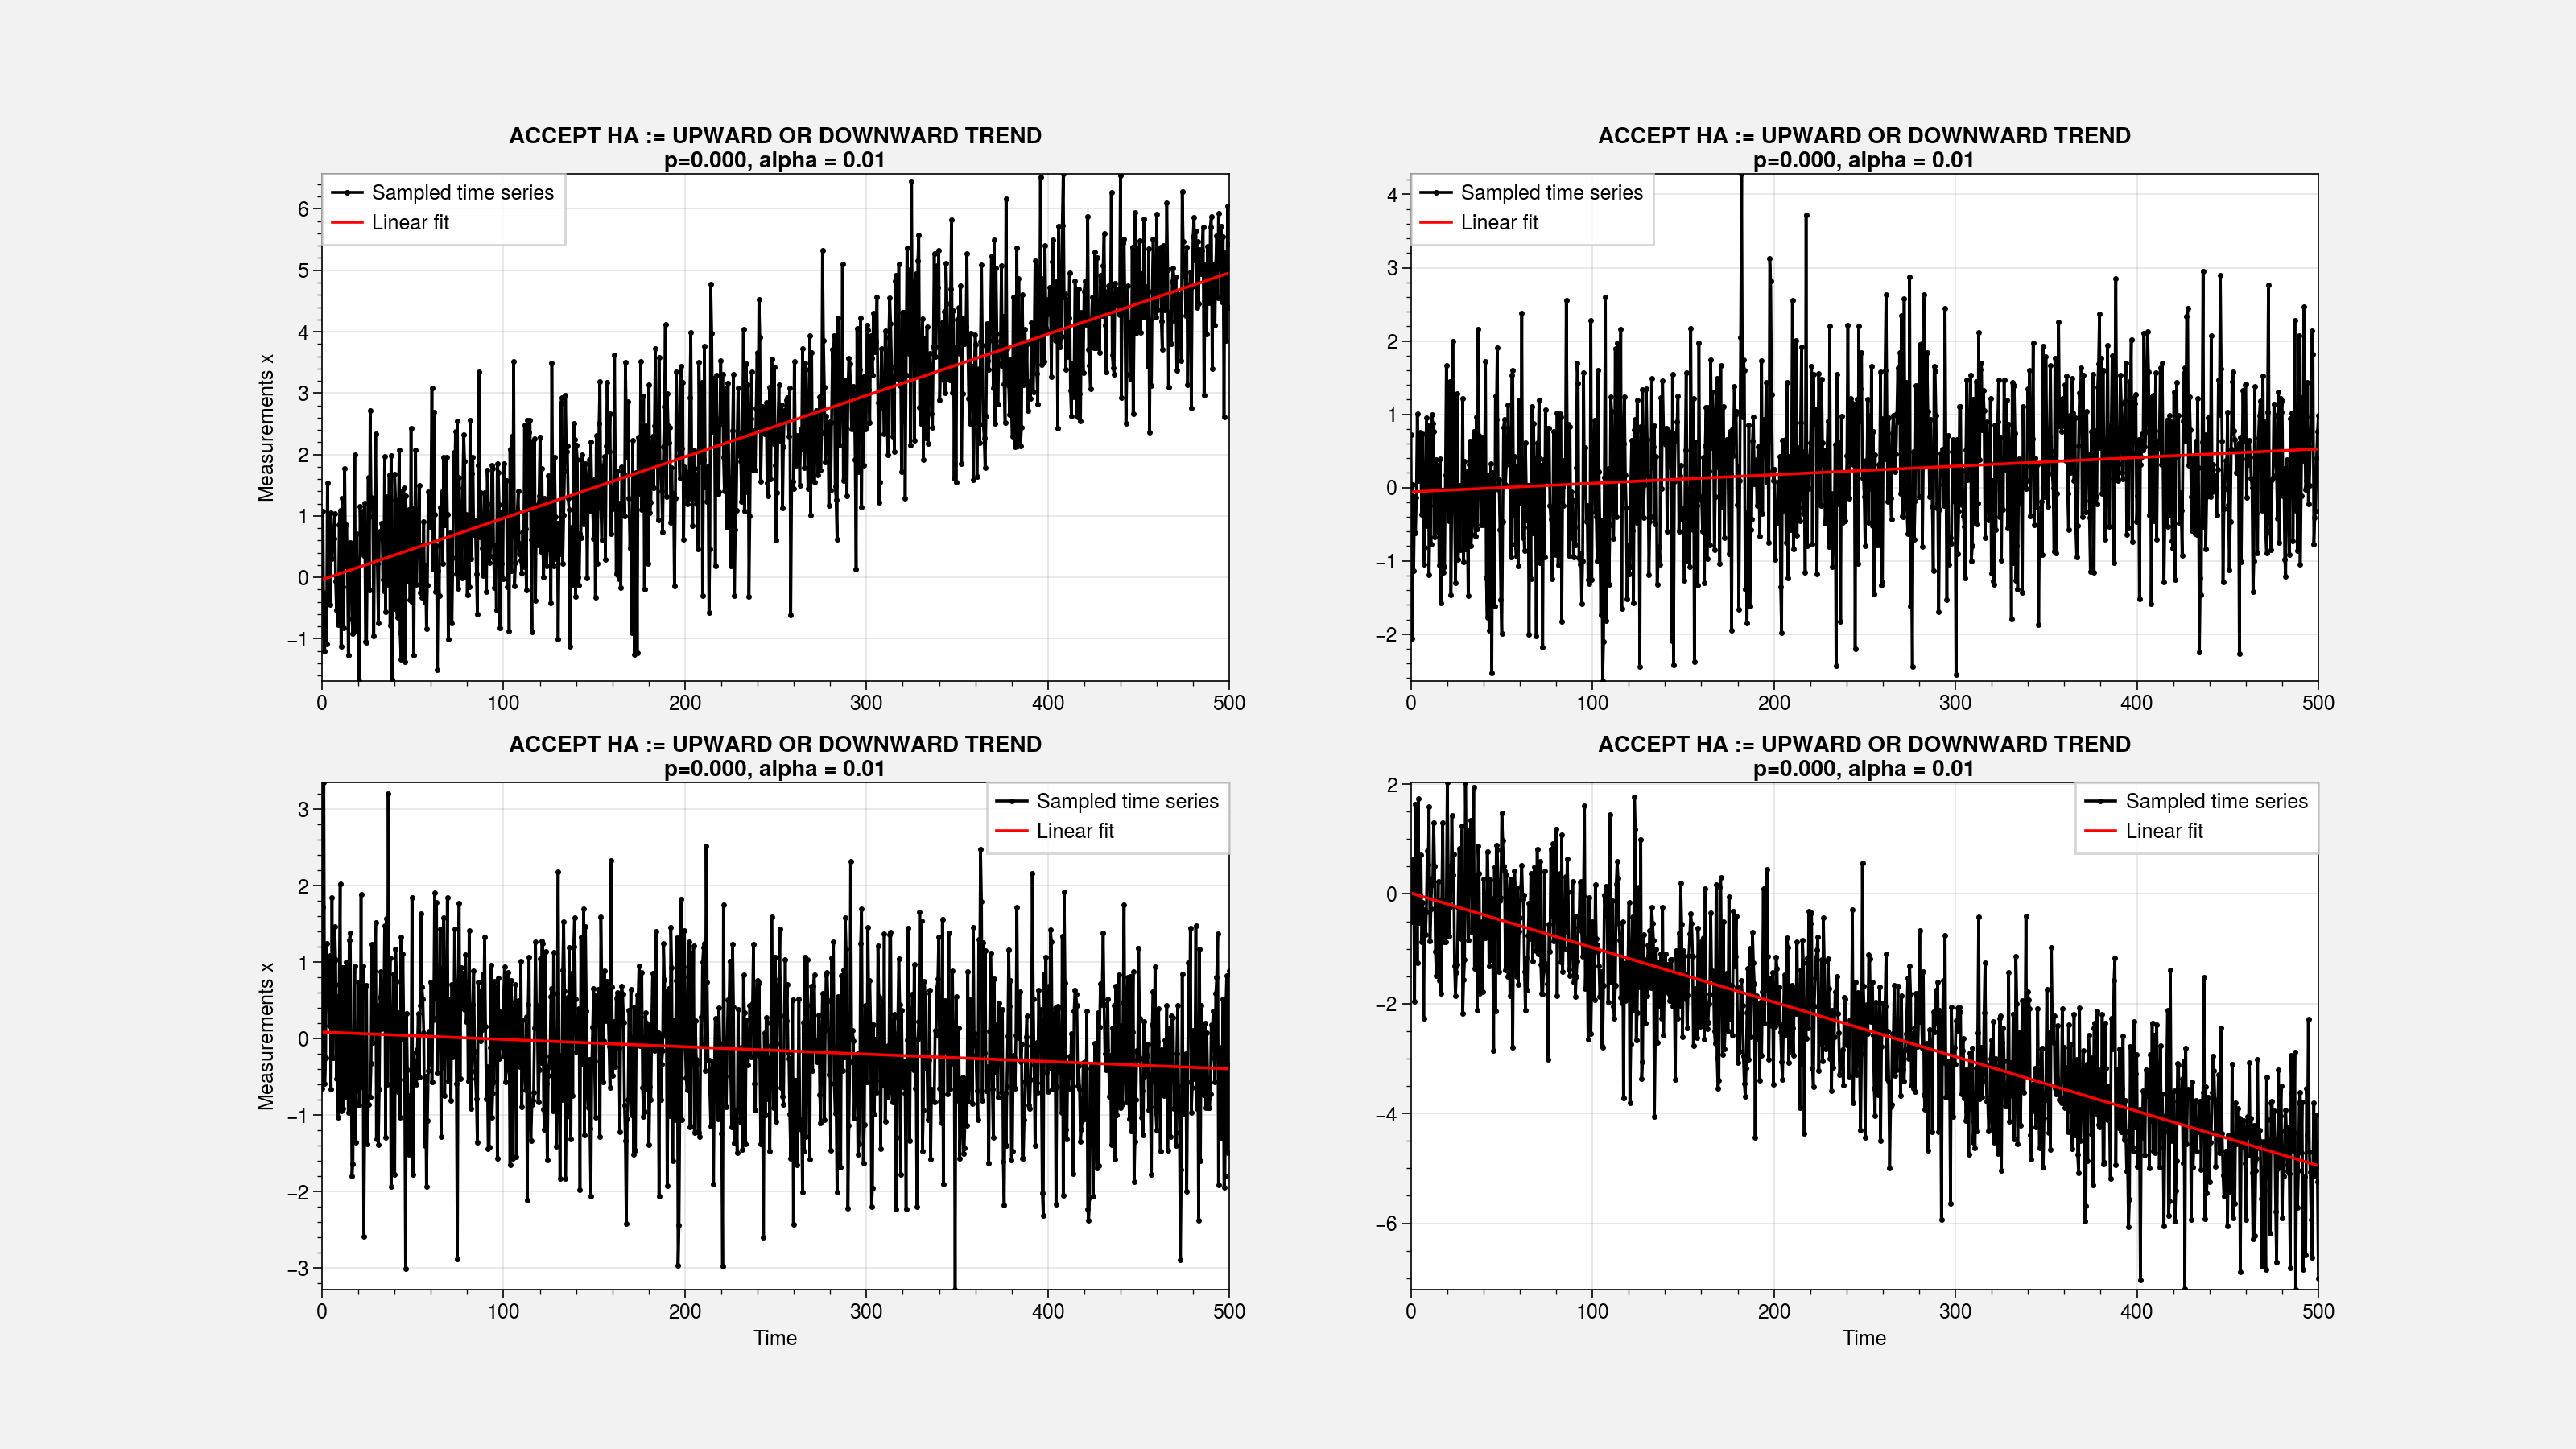

In [142]:
import matplotlib.pyplot as pl

station = 'ARCHERS POST'

def show_examples():
    """
    Returns the MK test results for artificial data.
    """
    # create artificial time series with trend
    n = 1000
    C = [0.01, 0.001, -0.001, -0.01]
    e = 1.00
    t = np.linspace(0., 500, n)

    # set up figure
    fig, axes = pl.subplots(nrows=2, ncols=2, figsize=[16.00, 9.00])

    # loop through various values of correlation
    ALPHA = 0.01
    for c, ax in zip(C, axes.flatten()):
        # estimate the measurements 'x'
        x = c * t +  e * np.random.randn(n)
        x = np.round(x, 2)

        # get the slope, intercept and pvalues from the mklt module
        MK, m, c, p = mkt.test(t, x, eps=1E-3, alpha=ALPHA, Ha="upordown")

        # plot results
        ax.plot(t, x, "k.-", label="Sampled time series")
        ax.plot(t, m * t + c, "r-", label="Linear fit")
        ax.set_title(MK.upper() + "\np=%.3f, alpha = %.2f" % (p, ALPHA),
                     fontweight="bold", fontsize=10)

        # prettify
        if ax.is_last_row():
            ax.legend(loc="upper right")
            ax.set_xlabel("Time")
        if ax.is_first_col():
            ax.set_ylabel(r"Measurements $x$")
        if ax.is_first_row():
            ax.legend(loc="upper left")

    # save/show plot
    pl.show(fig)
    return None

show_examples()

In [81]:
# Import metadata for the stations
md = pd.read_csv("../data/CETRAD/CETRADMetadata.csv")  # Read in the each stations metadata
md.head()

,Station Name,Annual Mean Rainfall,Annual SD Rainfall,prev_x,prev_y,UTM_x,UTM_y,Note
0,ARCHERS POST,355.741667,154.381690,351624.283,70807.012,351300.0,10065660.0,"UTM, 37 S"
1,ARDENCAPLE FARM,636.740616,226.335232,306006.828,9696.368,305700.0,10004460.0,These look like they've been rounded off
2,CASTLE FOREST STN,2033.627234,555.552122,311885.880,-44864.115,311700.0,9949860.0,NaN
3,CHOGORIA FOREST STN,2225.510714,609.475564,343375.885,-26140.191,343500.0,9968460.0,NaN
4,CHUKA FOREST STN,1915.845556,453.113081,344923.385,-34827.829,344700.0,9960060.0,NaN


In [82]:
md.describe()

,Annual Mean Rainfall,Annual SD Rainfall,prev_x,prev_y,UTM_x,UTM_y
count,80.000000,80.000000,73.000000,73.000000,77.000000,7.700000e+01
mean,846.456388,266.458853,280887.682932,4756.057425,280016.883117,1.000109e+07
std,366.869672,112.407249,38238.917088,33358.966855,37841.586017,3.147767e+04
min,355.557143,133.459860,194353.309000,-76827.970000,194100.000000,9.939060e+06
25%,636.573837,202.299506,263186.069000,-18075.287000,260100.000000,9.979860e+06
50%,725.021815,234.455798,284539.729000,4286.224000,284100.000000,9.999660e+06
75%,931.166310,291.891554,306006.828000,23732.173000,305700.000000,1.002006e+07
max,2225.510714,627.262341,351624.283000,122312.890000,351300.000000,1.011666e+07


In [83]:
# Return min, max, med:
md.sort_values(by='Annual Mean Rainfall')

# stations to use:
# L: OL JOGI FARM: 1967-1999, 32 years
# M: Kisima Farm
# H: TIMAU MARANIA: 1951-2015, # 64 years

,Station Name,Annual Mean Rainfall,Annual SD Rainfall,prev_x,prev_y,UTM_x,UTM_y,Note
39,MUKOGODO (NRM),355.557143,179.420270,284539.729,42749.591,284100.0,10037460.0,NaN
0,ARCHERS POST,355.741667,154.381690,351624.283,70807.012,351300.0,10065660.0,"UTM, 37 S"
16,JUNCTION (EWASO NAROK),446.788571,192.403063,260384.335,56118.819,260100.0,10051260.0,NaN
5,COLCHECCIO,450.030011,178.837883,255409.160,68804.307,255300.0,10062660.0,NaN
6,DOL DOL DAO,518.613513,215.823611,295573.860,43649.450,295500.0,10038660.0,NaN
...,...,...,...,...,...,...,...,...
32,MARIENE CRS,1717.150000,535.742714,349303.747,-934.868,348900.0,9993660.0,NaN
13,IRANGI FOREST STN,1750.950000,554.512513,331263.832,-38102.665,330900.0,9957060.0,NaN
4,CHUKA FOREST STN,1915.845556,453.113081,344923.385,-34827.829,344700.0,9960060.0,NaN
2,CASTLE FOREST STN,2033.627234,555.552122,311885.880,-44864.115,311700.0,9949860.0,NaN


In [85]:
df

,Value,"Inter-storm arrival, λ, (day$^{-1}$)",x_str
1934,0.326087,0.447767,1934
1935,0.489130,0.445114,1935
1936,0.489130,0.442461,1936
1937,0.391304,0.439808,1937
1938,0.315217,0.437155,1938
...,...,...,...
2010,0.336957,0.246151,2010
2011,0.217391,0.243498,2011
2012,0.369565,0.240846,2012
2013,0.326087,0.238193,2013


### Step 2. Filter data

TODO: Put the three locations in a list and loop through the following procedure to determine r2, etc.

In [86]:
#station = 'ARDENCAPLE FARM' # 67 years of data
#station = 'JACOBSON FARM'
#station = 'EMBORI FARM'
station = 'OL JOGI FARM'
#station = 'TIMAU MARANIA'
station = 'CASTLE FOREST STN'
columns = [station] + ['Year', 'Month', 'Datetime']

df = df_raw
rainfall = df[columns]
rainfall.head()

,CASTLE FOREST STN,Year,Month,Datetime
Datetime,,,,
1934-01-01,NaN,1934,1,1934-01-01
1934-01-02,NaN,1934,1,1934-01-02
1934-01-03,NaN,1934,1,1934-01-03
1934-01-04,NaN,1934,1,1934-01-04
1934-01-05,NaN,1934,1,1934-01-05


Check out the data

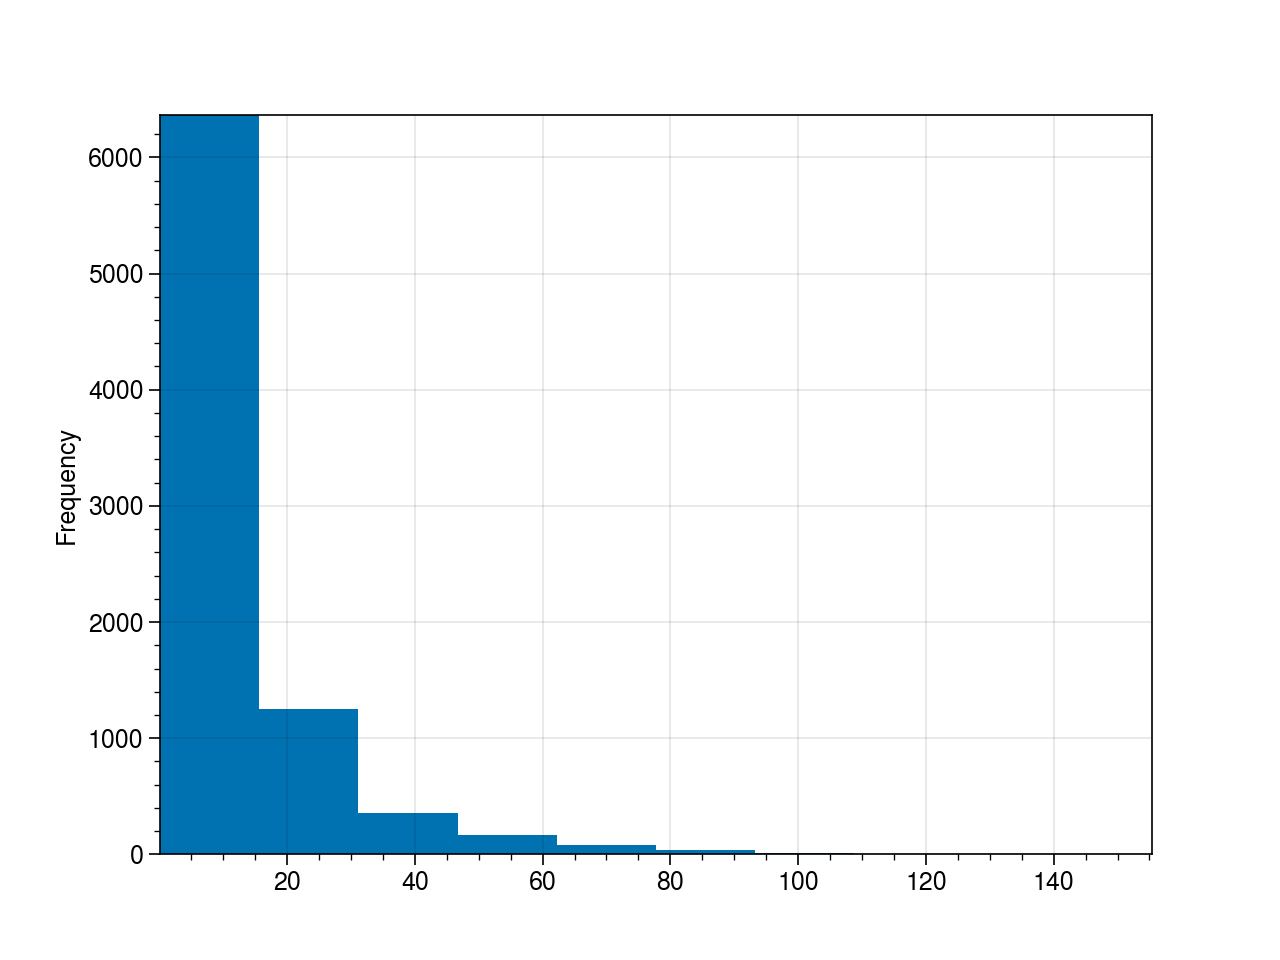

In [87]:
# Plot a histogram of rainfall values for days with rain.
daily_rainfall = rainfall.loc[rainfall[station] > 0][station]
daily_rainfall.plot.hist()

This looks okay, but we need to check and see how well the values in `daily_rainfall` fit our assumption of an exponential distribution.

### Step 3. Fit the distribution

To fit the distribution, we are going to use some more functions from `python`'s suite of numerical analysis. In this case we are going to use some functions from `scipy`. The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module has a large suite of distribution functions pre-defined, which we can use to develop a fit for our data. Using any of these distributions for fitting our data is very easy. The distribution we are most interested in is the exponential distribution, which is called `expon` in the `stats` module.

In [88]:
import scipy.stats as st

distribution = st.expon
data = daily_rainfall
params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

print(params)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

(0.1, 11.451907179115302)


### Step 4. Calculate fitted PDF and error with fit in distribution

To test the fit of our distribution, we can compare the empirical histogram to that predicted by our model. To do this, we first use our `data` to generate the empirical histogram. In this exampkle, we break the data into `30` bins, and we generate a histrogram of `density` rather than counts. This allows for an easier comparison between our empirical data and the fitted probability distribution function. Here are the steps:

1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
2. Shift the `x` bin locations generated from the histogram to the center of bins.
3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according to:

$$ SS_{error} = \sum_{i=1}^{n} \left(y_i - f(x_i)\right)^2 $$
$$ SS_{yy} = \sum_{i=1}^{n} \left(y_i - \bar{y}\right)^2 $$

5. Calculate the $r^2$ of the fit, according to

$$ r^2 = 1- \frac{SS_{error}}{SS_{yy}} $$ 

 

In [89]:
# Step 1. Generate a density histogram of the data 
y, x = np.histogram(data, bins=30, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )
print(r_2)

0.9563776840169299


This is an extremely good fit, so we can be confident that our assumption about an exponential distribution of rainfall is reasonable.

## Determining monthly values of  $\lambda_r$ 

We need to determine the probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month. For now, we assume stationarity in the monthly values, which means that we are assuming that the values of $\lambda_r$ in each month are the same through out the entire record (i.e. Jan 1938 has the same properties as Jan 2008). 

<div class="alert alert-info">💡 Test stationarity assumption </div>



As a first step, let's get all the `rain_days` and all of the `observation_days` from the data on `OL JOGI FARM`. We will use method chaining to run a **groupby()** as we go.

In [90]:
# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0]

rain_days.head()

,CASTLE FOREST STN,Year,Month,Datetime
Datetime,,,,
1959-03-01,6.1,1959,3,1959-03-01
1959-03-02,20.3,1959,3,1959-03-02
1959-03-03,8.1,1959,3,1959-03-03
1959-03-05,3.8,1959,3,1959-03-05
1959-03-08,1.3,1959,3,1959-03-08


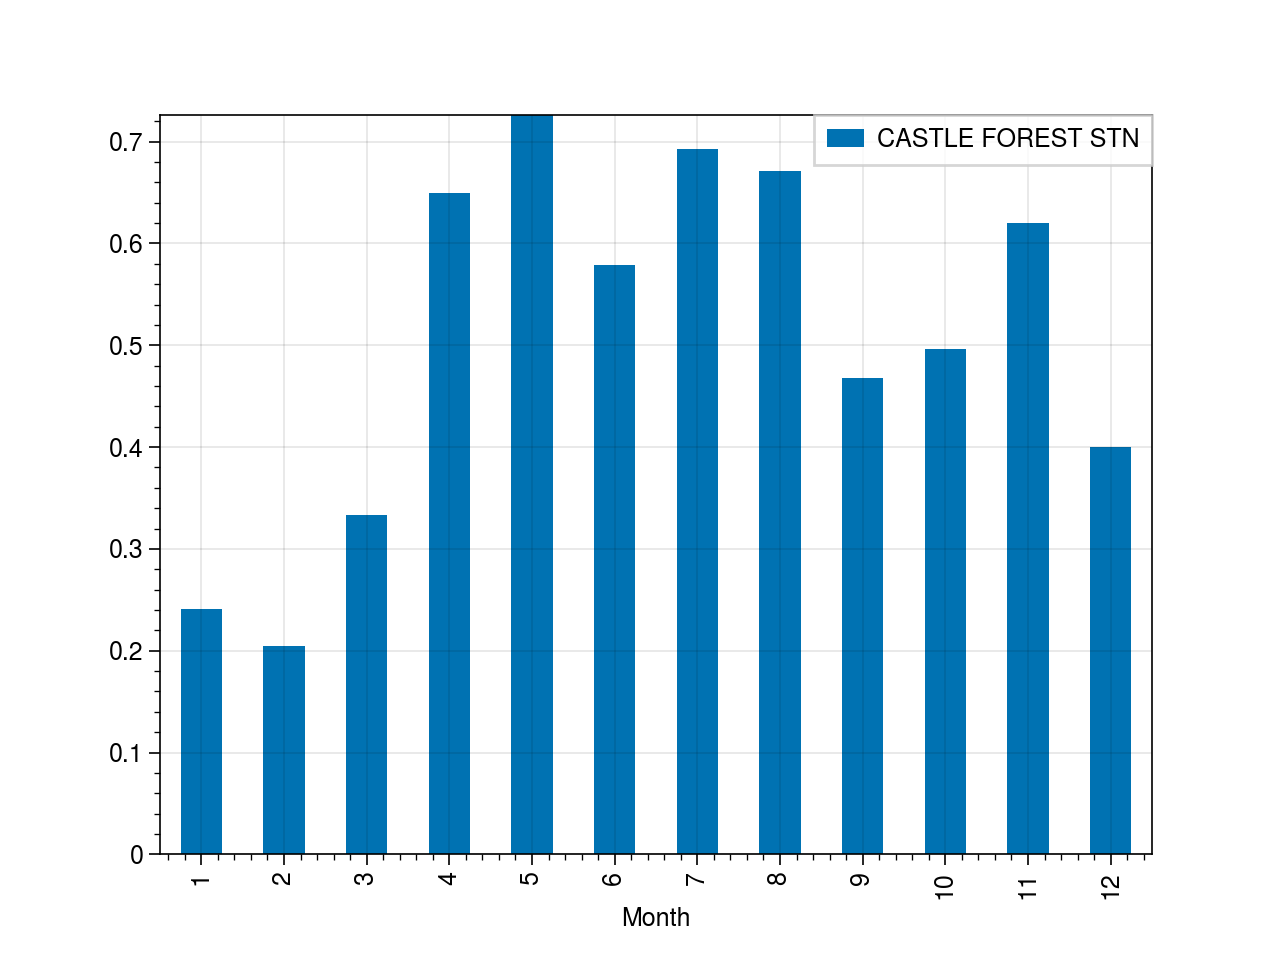

In [91]:
lambda_by_month = (
    rain_days.groupby('Month')[station].count() /
    all_days.groupby('Month')[station].count()
    )
pd.DataFrame(lambda_by_month).plot.bar()

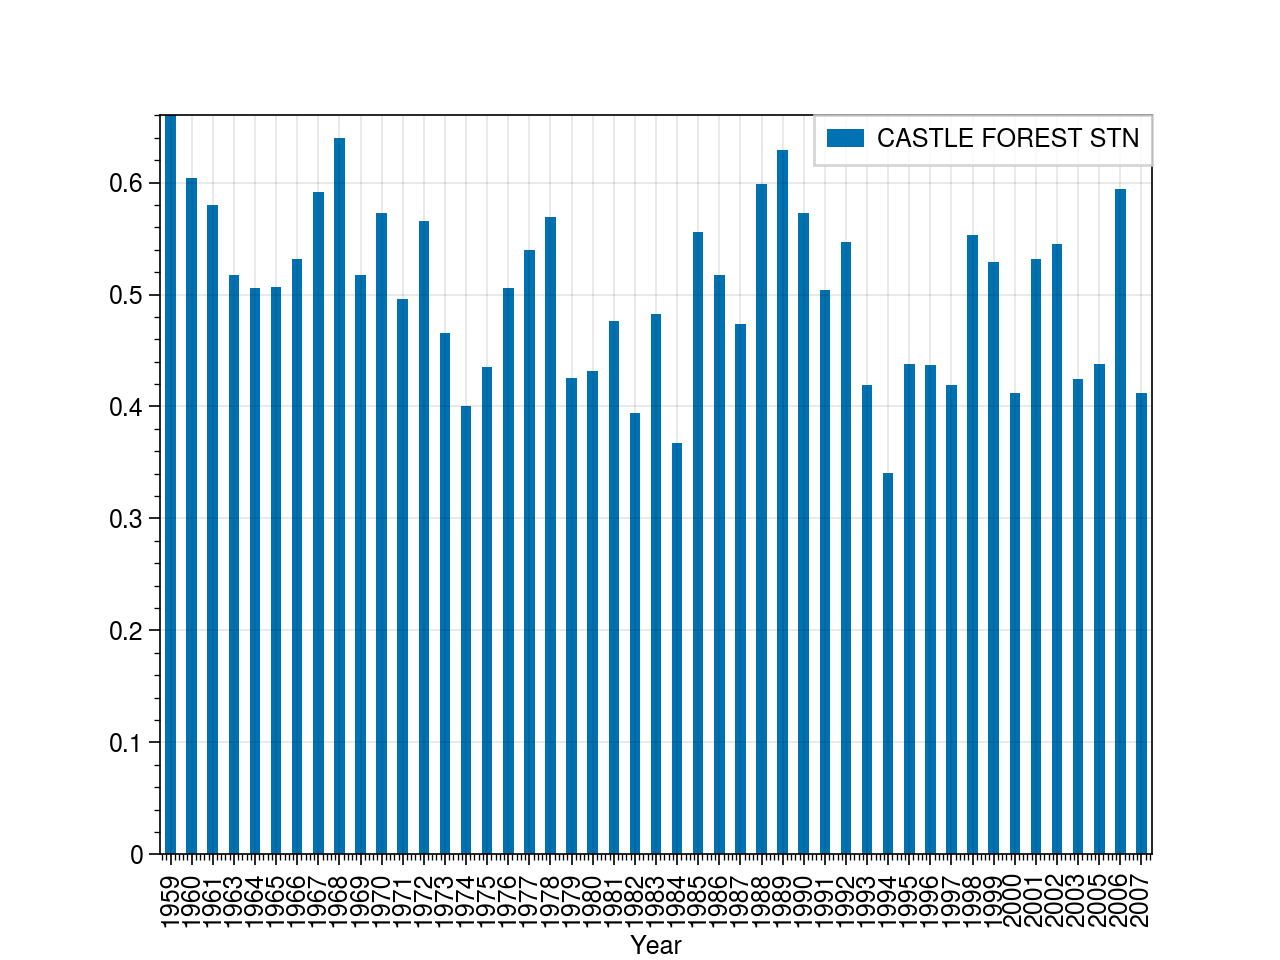

In [92]:
lambda_by_year = (
    rain_days.groupby('Year')[station].count() /
    all_days.groupby('Year')[station].count()
    )
pd.DataFrame(lambda_by_year).plot.bar()

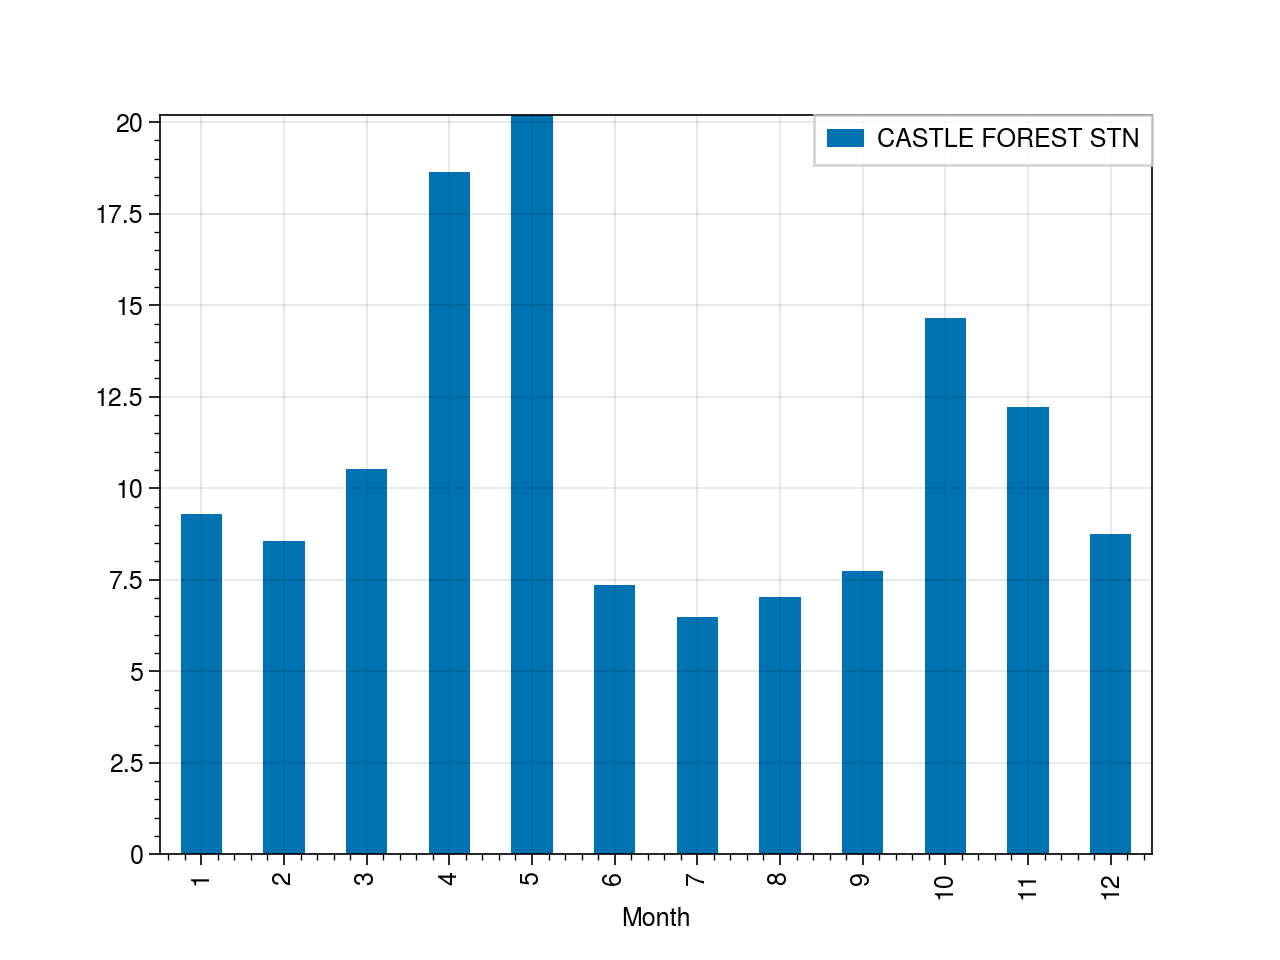

In [93]:
alpha_by_month = rain_days.groupby('Month')[station].mean()
pd.DataFrame(alpha_by_month).plot.bar()

In [94]:
climate = pd.DataFrame(alpha_by_month)
climate = climate.rename(columns={'OL JOGI FARM': 'alpha_by_month'})
climate['lambda_by_month'] = lambda_by_month
climate['days'] = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
climate['monthly_rainfall'] = climate['lambda_by_month'] * climate['alpha_by_month'] * climate['days']


climate_parameters = {
     'alpha_r': climate['alpha_by_month'].to_list(),
    'lambda_r': climate['lambda_by_month'].to_list(),
    'doy_start': 1,
    't_sim': 180,
    'ET_max': 6.5 
}

#dir(climate['alpha_by_month'])


climate = Climate(climate_parameters)

climate.rainfall.sum()

KeyError: 'alpha_by_month'

## Simulating annual rainfall

To simulate annual rainfall, we are going to specify daily values of $\lambda_r$ using the monthly values we just calculated. The use of a variable $\lambda$ value in a poisson process creates what is known as an "inhomogenous poisson process" (or, alternatively, "nonhomogeneous"... unfortunately, there isn't much homogeneity in what we call it!). These types of processes allow the properties of the process to change in space and time. Our implementation - using monthly values - is a little clunky, and we'd prefer to have the $\lambda$ values change more smoothly throughout the year. However, we probably don't have sufficient data to allow for this, even if we could accomodate the more complicated coding it would require. 

In order to generate our nonhomogenous process we will first generate a daily array of month numbers for the year `2018`. This is really easy in python using `datetime` + `timedelta` (which we need to import).

```python
    import datetime
    from datetime import timedelta
    datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
    month_value = np.array([datetime.month for datetime in datetimes])
```

In [21]:
from datetime import timedelta, datetime
datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

## ToDo #1
## turn this into dekad_value_by_day

Month
1     0.051808
2     0.051502
3     0.105572
4     0.272917
5     0.304435
6     0.138542
7     0.174395
8     0.150202
9     0.114583
10    0.209157
11    0.246237
12    0.093652
Name: OL JOGI FARM, dtype: float64


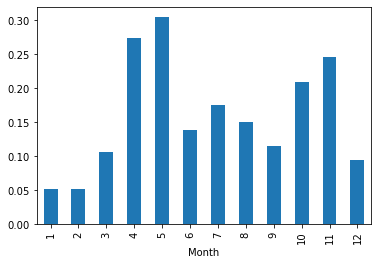

In [22]:
print(lambda_by_month)

## To-Do #1
## turn this into lambda_by_dekad

## To-Do #2
## turn this into plot, and plot for each station 
lambda_by_month.plot(kind='bar')

In [23]:
print(month_value_by_day)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11

`numpy` makes it really easy to map the values in one array onto the values of another.

```python
    lambda_values = [lambda_by_month[i] for i in month_value_by_day]
```

In [24]:
lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])

With daily values of $\lambda_r$, we only need to follow the same cookbook we used to make the seasonal data:

```python
    alpha = scale  # Let's use the value we estimated from our exponential fit.
    simulated_rainfall_values = np.random.exponential(
        scale=alpha, size=len(lambda_values)) # Use the len() function instead of a constant.
```

    

In [25]:
alpha = scale

simulated_rainy_days = (np.random.uniform(low=0, high=1, size=len(lambda_values)) <= lambda_values).astype(int)
simulated_rainfall_values = np.random.exponential(scale=alpha, size=len(lambda_values))

simulated_rainfall = simulated_rainy_days * simulated_rainfall_values

## Plotting our simulated data

We can easily plot our rainfall data using the `datetimes` object we already created as the basis of our x-axis.

<BarContainer object of 364 artists>

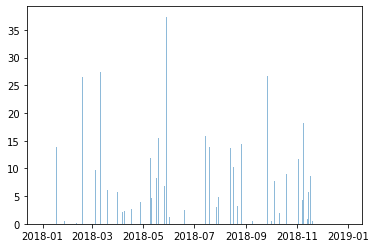

In [26]:
fig, ax = plt.subplots()

ax.bar(datetimes, simulated_rainfall, align='center', alpha=0.5)

<div class="alert alert-success">✏️ <strong>DIY Coding</strong>: Play around with our simulation. Here are a couple of ideas:</div>

1. Run 100 simulations of rainfall with our model for `JACOBSON FARM`. Compare the distribution of annual rainfall to the empirical distribution of annual rainfall.

2. Run the model for the same number of years that are in the `JACOBSON FARM` record and compare the mean and standard deviations of annual rainfall between the simulation and the empirical data. How well do they match?

2. Using the same simulations as in `2`, compare the mean and standard deviations of monthly rainfall between the simulation and the empirical data.

3. We've made $\lambda_r$ change every month, but we've used a constant $\alpha$ value. Determine if the assumption of a constant $\alpha$ is reasonable.

4. Determine the model parameters for a different station, preferably one with much lower or higher rainfall. How do the values of $\alpha$ and $\lambda_r$ change between stations?

5. Earlier I touched on the idea of non-stationarity in which the values of $\lambda_r$ and/or $\alpha$ may be changing over time. If you're up for it, see if you can come up with a way to investigate if our assumption of stationarity is valid.


In [99]:
# Not necessary


## 2. Simulate rainfall totals

Using a $\lambda_r$ value of <code>0.40</code>, and assuming that the length of a growing season, $T_{seas}$, is 100 days, simulate a season of rainfall "events", where the value of a day is <code>1</code> if rainfall occurs, and <code>0</code> if not.

In [2]:
T_seas = 100 # Days in each season
N_seas = 100 # Number of seasons to simulate
alpha = 11
s_mat = np.random.uniform(low=0, high=1, size=[N_seas, T_seas])
amounts = np.random.exponential(scale=alpha, size=[N_seas, T_seas])

lam = 0.4 # Lambda value
rain_days = np.array(s_mat <= lam).astype(int)
rain = rain_days * amounts
rain.sum(axis=1).std()/rain.sum(axis=1).mean() # Analytical equation for this!

0.20865081911871655